<a href="https://colab.research.google.com/github/SofiaSchweitzer/ML4Physics_Summer_School/blob/main/Omnifold_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Omnifold Tutorial #

##### Import relevant libaries #####

In [ ]:
import torch
import torch.nn as nn
import time

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


#### Interesting papers
OmniFold: A Method to Simultaneously Unfold All Observables <br> *Anders Andreassen, Patrick T. Komiske, Eric M. Metodiev, Benjamin Nachman and Jesse Thaler*<br>https://arxiv.org/pdf/1911.09107

We are going to work with the dataset from https://zenodo.org/records/3548091.

Load data

In [ ]:
!wget "https://www.dropbox.com/scl/fo/88muusw0kecnxv2644ve6/AG8Ov6PSx7UfxPk328qoP-w?rlkey=stexzrk8t0f0almhrkq32ey3l&st=edyovawd&dl=1"
!unzip "AG8Ov6PSx7UfxPk328qoP-w?rlkey=stexzrk8t0f0almhrkq32ey3l&st=edyovawd&dl=1"

--2025-06-28 18:56:11--  https://www.dropbox.com/scl/fo/88muusw0kecnxv2644ve6/AG8Ov6PSx7UfxPk328qoP-w?rlkey=stexzrk8t0f0almhrkq32ey3l&st=edyovawd&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd5ac6f6f9a773013eb9f6c47dd.dl.dropboxusercontent.com/zip_download_get/CP7WNWcLZCSp1X4pgG7BcWhoRUxgdXLqXqs2Q36JdpsWmtHIfE0LEeoDpRc7izT7rOZDHP6HRUPdcOaLP6qFQBBiHvh6dFUPlWKkyC71Mp4t1w# [following]
--2025-06-28 18:56:11--  https://ucd5ac6f6f9a773013eb9f6c47dd.dl.dropboxusercontent.com/zip_download_get/CP7WNWcLZCSp1X4pgG7BcWhoRUxgdXLqXqs2Q36JdpsWmtHIfE0LEeoDpRc7izT7rOZDHP6HRUPdcOaLP6qFQBBiHvh6dFUPlWKkyC71Mp4t1w
Resolving ucd5ac6f6f9a773013eb9f6c47dd.dl.dropboxusercontent.com (ucd5ac6f6f9a773013eb9f6c47dd.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to ucd5ac6f6f9a773013eb9

In [ ]:
reco_sim = torch.tensor(np.load("reco_MC.npy"), dtype=torch.float)
reco_data = torch.tensor(np.load("reco_data.npy"), dtype=torch.float)
part_sim = torch.tensor(np.load("part_MC.npy"),  dtype=torch.float)
part_data = torch.tensor(np.load("part_data.npy"),  dtype=torch.float)

Build training and test datasets if needed

In [ ]:
reco_sim_train, reco_sim_test = reco_sim[:750000], reco_sim[750000:]
reco_data_train, reco_data_test = reco_data[:750000], reco_data[750000:]
part_sim_train, part_sim_test = part_sim[:750000], part_sim[750000:]

We will define some preprocessing functions to apply to the data.

In [ ]:
mean = torch.tensor([ 0.1411, -6.9493,  0.6731])
std = torch.tensor([0.0960, 2.2009, 0.2031])

In [ ]:
def preprocess(data, mean, std, device="cpu", reverse=False):
    """
    Standardizes or un-standardizes the data.

    Args:
        data (Tensor): The input data tensor.
        mean (Tensor or float): The mean used for standardization.
        std (Tensor or float): The standard deviation used for standardization.
        device (str or torch.device): The device to move the tensor to ('cpu' or 'cuda').
        reverse (bool): If True, reverses the standardization (un-normalize).

    Returns:
        Tensor: Processed data tensor.
    """
    if not reverse:
        data = (data - mean) / std
        return data.to(device)
    else:
        return (data.cpu() * std) + mean


In [ ]:
# Clone and preprocess the data to standardize input features with reco-level MC mean and standard deviation.

reco_sim_proc_train = preprocess(reco_sim_train.clone(), mean, std, device=device)
reco_sim_proc_test = preprocess(reco_sim_test.clone(), mean, std, device=device)

reco_data_proc_train = preprocess(reco_data_train.clone(), mean, std, device=device)

part_sim_proc_train = preprocess(part_sim_train.clone(), mean, std, device=device)
part_sim_proc_test = preprocess(part_sim_test.clone(), mean, std, device=device)

### Exercise 1 – Building a Classifier in PyTorch

In this first exercise, we will implement a flexible binary classifier using PyTorch, which will then serve as a core component in the OmniFold algorithm.

The aim is to build a reusable classifier class. This modular design allows us to train and evaluate the classifier multiple times throughout the unfolding process.

#### Structure of the Classifier

Your classifier should be implemented as a Python class with the following components:

1. **Initialization (`__init__`)**  
   Here, we define:
   - `dims_in`: the number of input features,
   - `params`: a dictionary of hyperparameters (such as learning rate, network size, and number of training epochs).

2. **Building Network (`init_network`)**  
   Define a fully connected feedforward neural network with:
   - One input layer,
   - A configurable number of hidden layers using ReLU activations,
   - A final output layer with a single unit producing logits.

3. **Loss Function (`batch_loss`)**  
   Implement a method that computes the weighted binary cross-entropy loss for a given batch of:
   - input features `x`,
   - labels `y`,
   - sample weights `w`.

4. **Training Loop (`train_classifier`)**  
   Create a training loop that:
   - Accepts data (`data_true`) and sim(`data_fake`) samples,
   - Optionally takes sample weights for each,
   - Trains the classifier using the Adam optimizer and a learning rate scheduler.

5. **Evaluation (`evaluate`)**  
   Evaluate the classifier on new data and return either:
   - `exp(logit)`, which gives the likelihood ratio (used for reweighting),
   - or `sigmoid(logit)`, which gives the predicted signal probability.




In [ ]:
class Classifier(nn.Module):
    def __init__(self, dims_in, params):
        """
        Initializes the classifier model.

        Args:
            dims_in (int): Dimensionality of input features.
            params (dict): Dictionary of model and training hyperparameters.
        """
        super().__init__()
        self.dims_in = dims_in
        self.params = params
        self.init_network()

    def init_network(self):
        """
        Initializes a fully connected feedforward neural network.
        """
        layers = []
        layers.append(nn.Linear(self.dims_in, self.params["internal_size"]))
        layers.append(nn.ReLU())
        for _ in range(self.params["hidden_layers"]):
            layers.append(nn.Linear(self.params["internal_size"], self.params["internal_size"]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.params["internal_size"], 1))
        self.network = nn.Sequential(*layers)

    def batch_loss(self, x, y, w):
        """
        Computes the weighted BCE loss for a batch.

        Args:
            x (Tensor): Input features.
            y (Tensor): Labels (0 or 1).
            w (Tensor): Sample weights.

        Returns:
            Tensor: Scalar loss value.
        """
        pred = self.network(x).squeeze()
        loss = torch.nn.BCEWithLogitsLoss(weight=w)(pred, y)
        return loss

    def train_classifier(self,
                         data_true,
                         data_fake,
                         weights_true=None,
                         weights_fake=None):
        """
        Trains the classifier on provided true (y=1) and fake (y=0) data.

        Args:
            data_true (Tensor): Data with label 1.
            data_fake (Tensor): Data with label 0.
            weights_true (Tensor): Optional weights for true data.
            weights_fake (Tensor): Optional weights for fake data.
        """

        device = data_true.device
        dtype = data_true.dtype

        if weights_true is None:
            weights_true = torch.ones((data_true.shape[0]), device=device, dtype=dtype)

        if weights_fake is None:
            weights_fake = torch.ones((data_fake.shape[0]), device=device, dtype=dtype)

        loader_true = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(data_true, weights_true),
            batch_size=self.params["batch_size"], shuffle=True,
            generator=torch.Generator(device))

        loader_fake = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(data_fake, weights_fake),
            batch_size=self.params["batch_size"], shuffle=True,
            generator=torch.Generator(device))

        optimizer = torch.optim.Adam(self.network.parameters(), lr=self.params["lr"])
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=self.params.get("max_lr", 3 * self.params["lr"]),
            epochs=self.params["n_epochs"],
            steps_per_epoch=min(len(loader_true), len(loader_fake)))

        print(f"Training classifier for {self.params['n_epochs']} epochs with lr {self.params['lr']}")
        t0 = time.time()

        for epoch in range(self.params["n_epochs"]):
            losses = []
            for (x_true, w_true), (x_fake, w_fake) in zip(loader_true, loader_fake):
                label_true = torch.ones((x_true.shape[0]), device=device, dtype=dtype)
                label_fake = torch.zeros((x_fake.shape[0]), device=device, dtype=dtype)

                optimizer.zero_grad()
                loss = self.batch_loss(x_true, label_true, w_true)
                loss += self.batch_loss(x_fake, label_fake, w_fake)
                loss.backward()
                optimizer.step()
                scheduler.step()
                losses.append(loss.item())

            if epoch % max(1, self.params["n_epochs"] // 5) == 0:
                print(f"    Epoch {epoch}: Avg loss = {torch.tensor(losses).mean():.4f}, Time = {round(time.time() - t0, 1)}s")

        print(f"Training finished in {round(time.time() - t0, 1)} seconds.")

    def evaluate(self, data, return_weights=True):
        """
        Evaluates the classifier.

        Args:
            data (Tensor): Input data.
            return_weights (bool): If True, returns likelihood ratios (exp(logits)).

        Returns:
            Tensor: Predicted weights or probabilities.
        """
        predictions = []
        with torch.no_grad():
            for batch in torch.split(data, self.params["batch_size_sample"]):
                pred = self.network(batch).squeeze().detach()
                predictions.append(pred)
        predictions = torch.cat(predictions)
        return predictions.exp().clip(0, 30) if return_weights else torch.sigmoid(predictions)

As we are going to need a lot of plots showing the reweighted distributions we will define a plot function

In [ ]:
FONTSIZE = 14

def plot_reweighted_distribution(true,
                                 fake,
                                 weights,
                                 bins=50,
                                name=None):
    """
    Plots the distribution of a single feature for:
      - true data,
      - fake data (raw),
      - fake data reweighted by weights.

    Args:
        true (Tensor): True data of shape [N, ].
        fake (Tensor): Fake data of shape [N, ].
        weights (Tensor): Weights for fake data, shape [N].
        bins (int): Number of bins in the histogram.
    """
    # Plot
    plt.figure(figsize=(6, 4))
    plt.hist(fake, bins=bins, label="Sim ", density=True, color="royalblue", histtype="step")
    plt.hist(fake, bins=bins, weights=weights, label="Sim (reweighted)", density=True, color="darkred", histtype="step")
    plt.hist(true, bins=bins, label="Data", density=True, color="black", histtype="step")

    plt.xlabel(r"${%s}$" % name,
               fontsize=FONTSIZE)

    plt.ylabel("Density",
              fontsize=FONTSIZE)

    plt.legend(frameon=False, fontsize=FONTSIZE)
    plt.tight_layout()
    plt.show()

### Exercise 2 - Single Iteration Omnifold

To get a better understanding of omnifold we will start by doing the first iteration explicitly. For one iteration implement the following steps:

1. Train a classifier between $p_{\text{sim}}(x_{\text{reco}})$ and $p_{\text{data}}(x_{\text{reco}})$

In [ ]:
# Define classifier parameteres

classifier_params = {"hidden_layers": 4,
                     "internal_size": 64,
                     "lr": 1.e-3,
                     "n_epochs" : 30,
                     "batch_size" : 1024,
                     "batch_size_sample": 2000}

n_features = reco_sim_test.shape[1]

binning = [torch.linspace(0, 0.6, 40 + 1),
           torch.linspace(-13, -2, 40 + 1),
           torch.linspace(0.1, 1.1, 40 + 1)]

names = [r"\text{Jet width } w",
         r"\text{Groomed mass }\log \rho",
         r"\text{N-subjettiness ratio } \tau_{21}"]


In [ ]:
# Build the classifier
reco_classifier = Classifier(dims_in=3, params=classifier_params).to(device)

# Train the classifier using reco-level data (true) and reco-level simulation (fake)
reco_classifier.train_classifier(
    data_true=reco_data_proc_train,
    data_fake=reco_sim_proc_train,
)

Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3681, Time = 24.9s
    Epoch 6: Avg loss = 1.3652, Time = 172.2s
    Epoch 12: Avg loss = 1.3650, Time = 319.5s
    Epoch 18: Avg loss = 1.3646, Time = 469.5s
    Epoch 24: Avg loss = 1.3642, Time = 617.5s
Training finished in 741.1 seconds.


2. Evaluate $w_\theta(x_\text{reco})$ with $x_\text{reco} \sim p_{\text{sim}}(x_{\text{reco}})$

In [ ]:
w_reco_train = reco_classifier.evaluate(
    data=reco_sim_proc_train,
)
w_reco_test = reco_classifier.evaluate(
    data=reco_sim_proc_test,
)

3. Plot $p_\text{sim}(x_\text{reco})$, $p_{\text{data}}(x_{\text{reco}})$ and $w_\theta(x_\text{reco})p_\text{sim}(x_\text{reco})$

cpu
cpu
cuda:0


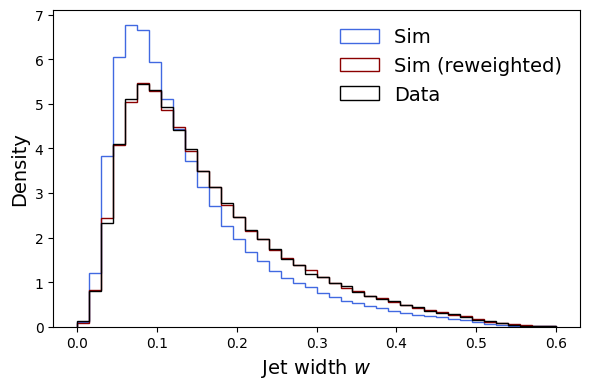

cpu
cpu
cuda:0


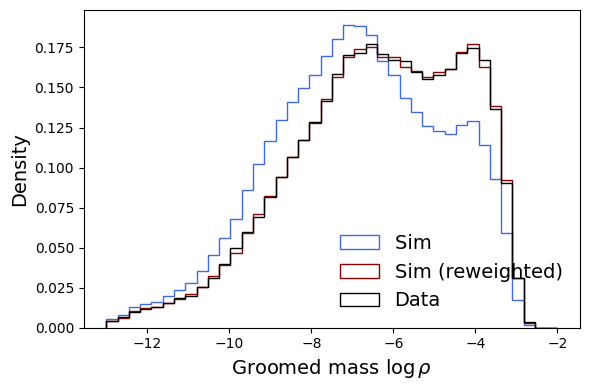

cpu
cpu
cuda:0


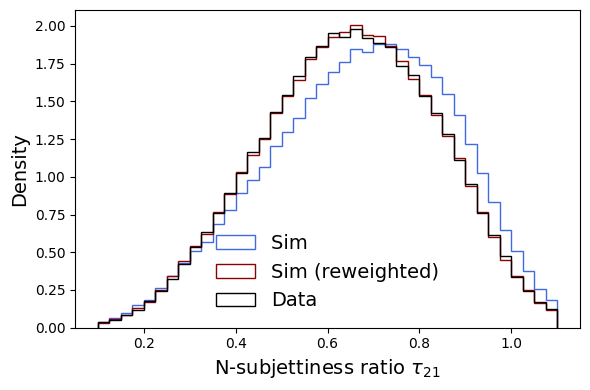

In [ ]:
for i in range(n_features):
  plot_reweighted_distribution(
        true=reco_data_test[:, i],
        fake=reco_sim_test[:, i],
        weights=w_reco_test.cpu(),
        bins= binning[i].cpu(),
        name = names[i]
    )

4. Pull the reco-level event to particle-level $w_\theta(x_\text{reco}) \rightarrow w_\theta(x_\text{part})$ using the pairing in simulation
   
5. Plot $p_\text{sim}(x_\text{part})$, $p_{\text{data}}(x_{\text{part}})$ and $w_\theta(x_\text{part})p_\text{sim}(x_\text{part})$

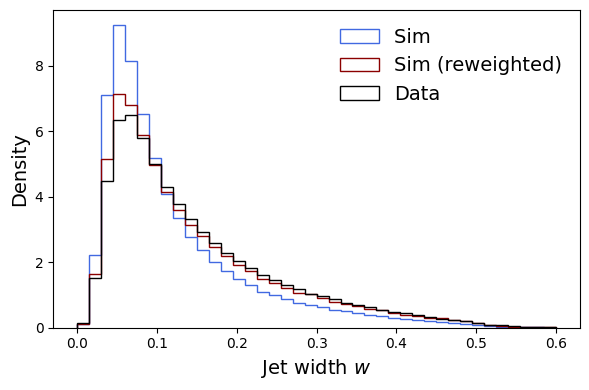

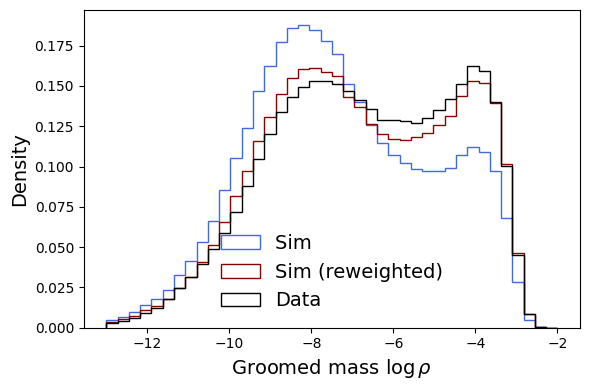

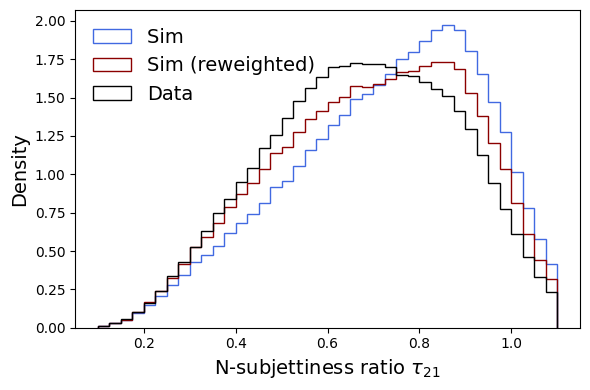

In [ ]:
for i in range(n_features):
    plot_reweighted_distribution(
        true=part_data[:, i],
        fake=part_sim_test[:, i],
        weights=w_reco_test.cpu(),
        bins= binning[i].cpu(),
        name = names[i]
    )

##### What do you observe?

6. Train a classifier between $p_{\text{sim}}(x_{\text{part}})$ and $w_\theta (x_\text{part}) p_{\text{sim}}(x_{\text{part}})$

In [ ]:
# Build the classifier
part_classifier = Classifier(dims_in=3, params=classifier_params)

# Train the classifier using reoc-level data (true) and reco-level simulation (fake) data
part_classifier.train_classifier(
    data_true=part_sim_proc_train,
    data_fake=part_sim_proc_train,
    weights_true= w_reco_train
)

Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3725, Time = 26.0s
    Epoch 6: Avg loss = 1.3709, Time = 183.2s
    Epoch 12: Avg loss = 1.3709, Time = 341.0s
    Epoch 18: Avg loss = 1.3709, Time = 496.4s
    Epoch 24: Avg loss = 1.3708, Time = 651.3s
Training finished in 779.3 seconds.


7. Evaluate $\nu_\phi (x_\text{part})$ with $x_\text{part} \sim p_\text{sim}(x_\text{part})$

In [ ]:
nu_part_train = part_classifier.evaluate(
    data=part_sim_proc_train,
)
nu_part_test = part_classifier.evaluate(
    data=part_sim_proc_test,
)

8. Plot $p_\text{sim}(x_\text{part})$, $p_{\text{data}}(x_{\text{part}})$ and $\nu_\phi(x_\text{part})p_\text{sim}(x_\text{part})$

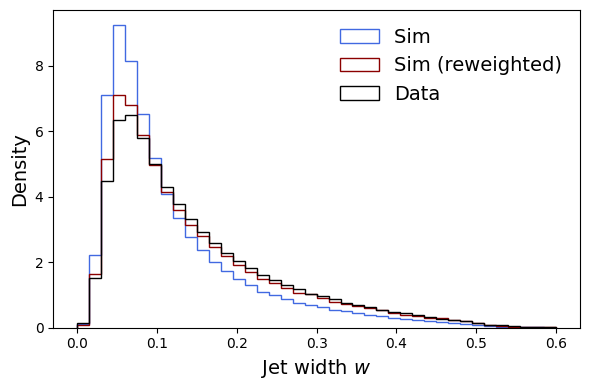

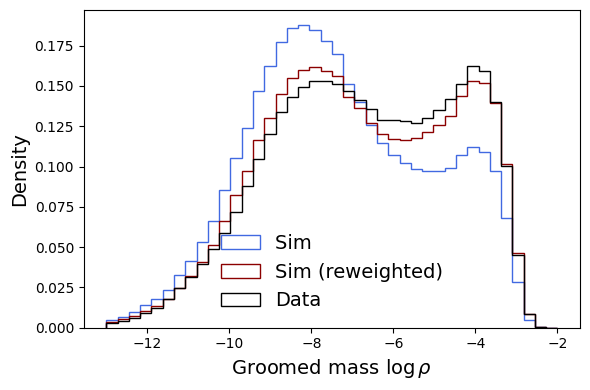

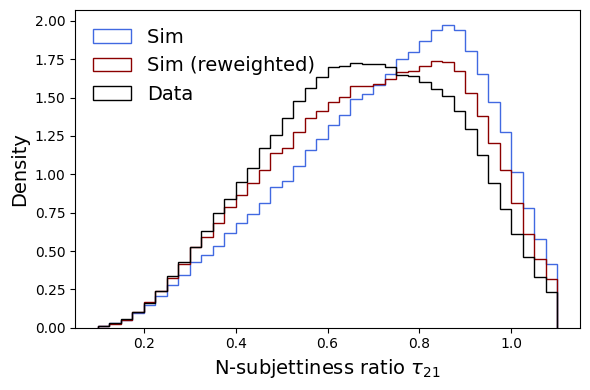

In [ ]:
for i in range(n_features):
    plot_reweighted_distribution(
        true=part_data[:, i],
        fake=part_sim_test[:, i],
        weights=nu_part_test.cpu(),
        bins= binning[i].cpu(),
        name = names[i]
    )

9. Push the particle-level event to reco-level $\nu_\phi(x_\text{part}) \rightarrow \nu_\phi(x_\text{reco})$ using the pairing in simulation

10. Plot $p_\text{sim}(x_\text{reco})$, $p_{\text{data}}(x_{\text{reco}})$ and $\nu_\phi(x_\text{reco})p_\text{sim}(x_\text{reco})$

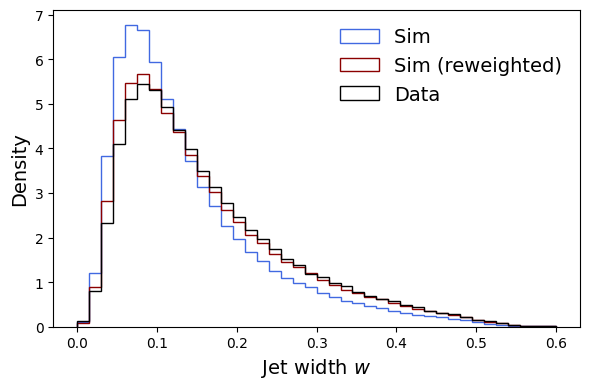

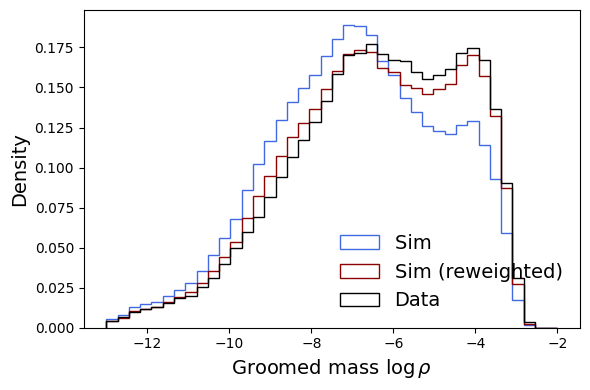

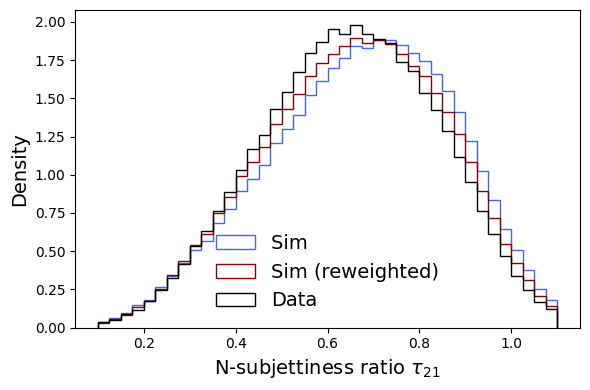

In [ ]:
for i in range(n_features):
    plot_reweighted_distribution(
        true=reco_data_test[:, i],
        fake=reco_sim_test[:, i],
        weights=nu_part_test.cpu(),
        bins= binning[i].cpu(),
        name = names[i]
    )

##### What do you observe?

### Exercise 3 - Iterative Omnifold

Now that we have walked through a single iteration of OmniFold step-by-step, it's time to automate the full iterative unfolding procedure.
Add all indivual steps to an iterative loop.

Starting with iteration 0
Building reco-level classifier
Training reco-level classifier
Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3689, Time = 13.8s
    Epoch 6: Avg loss = 1.3651, Time = 100.8s
    Epoch 12: Avg loss = 1.3649, Time = 186.2s
    Epoch 18: Avg loss = 1.3645, Time = 273.3s
    Epoch 24: Avg loss = 1.3641, Time = 357.6s
Training finished in 428.4 seconds.
Evaluating reco-level classifier
Plotting reweighted reco-level distribtuion


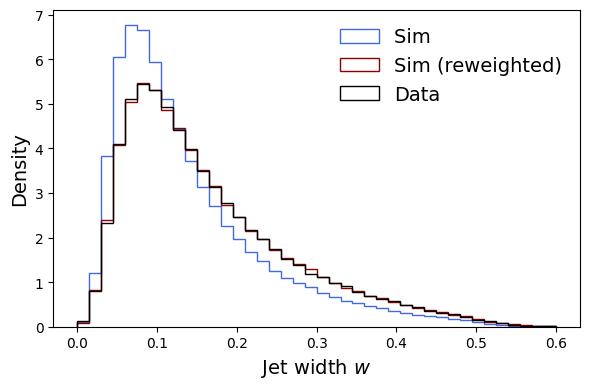

Plotting reweighted particle-level distribtuion


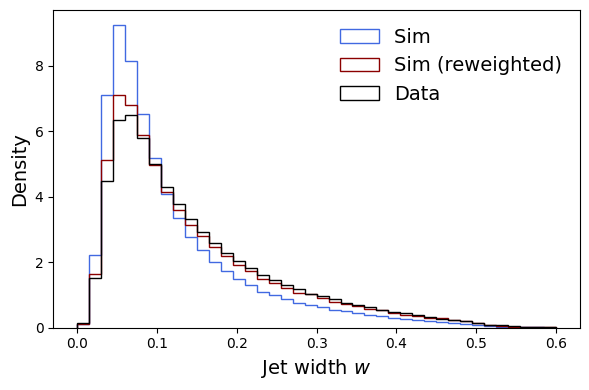

Plotting reweighted reco-level distribtuion


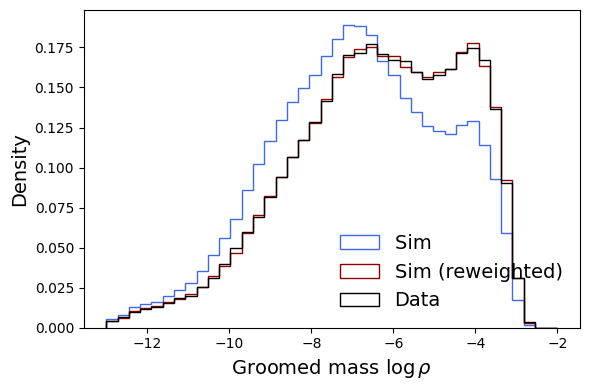

Plotting reweighted particle-level distribtuion


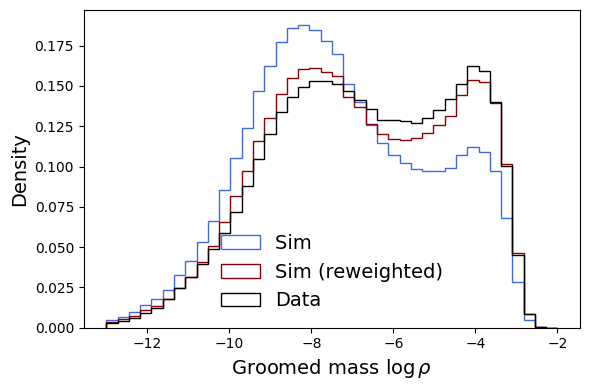

Plotting reweighted reco-level distribtuion


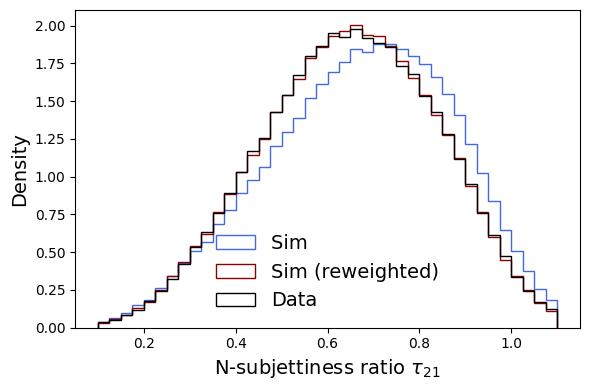

Plotting reweighted particle-level distribtuion


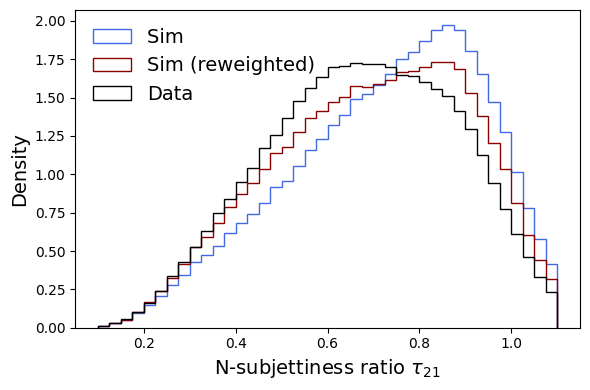

Building part-level classifier
Training part-level classifier
Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3725, Time = 14.5s
    Epoch 6: Avg loss = 1.3709, Time = 99.2s
    Epoch 12: Avg loss = 1.3708, Time = 183.9s
    Epoch 18: Avg loss = 1.3708, Time = 271.2s
    Epoch 24: Avg loss = 1.3708, Time = 357.8s
Training finished in 429.8 seconds.
Evaluating part-level classifier
Plotting reweighted reco-level and particle-level observables.
Plotting reweighted particle-level distribtuion


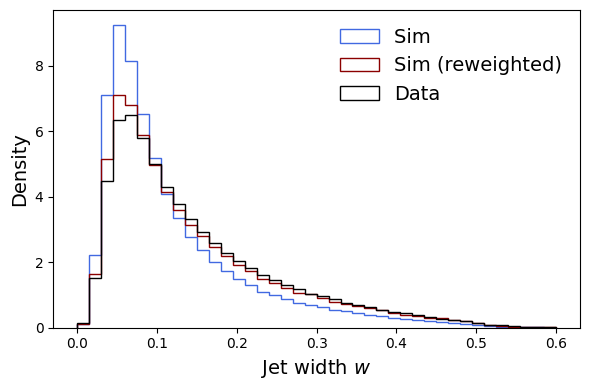

Plotting reweighted reco-level distribtuion


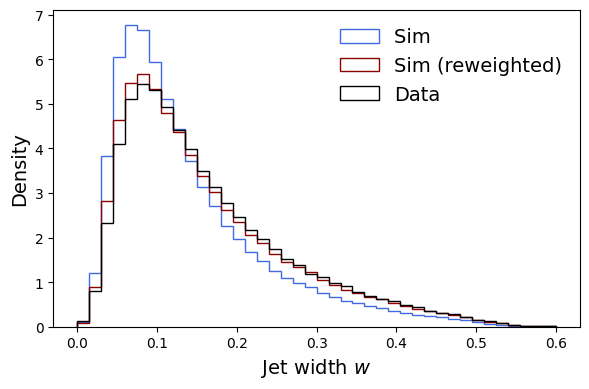

Plotting reweighted particle-level distribtuion


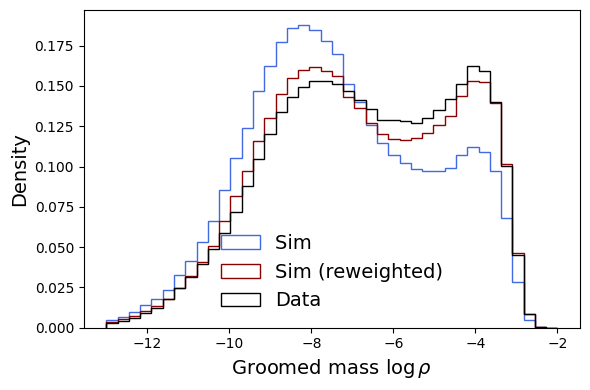

Plotting reweighted reco-level distribtuion


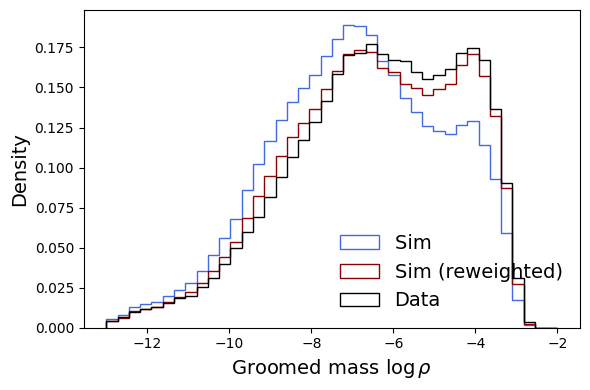

Plotting reweighted particle-level distribtuion


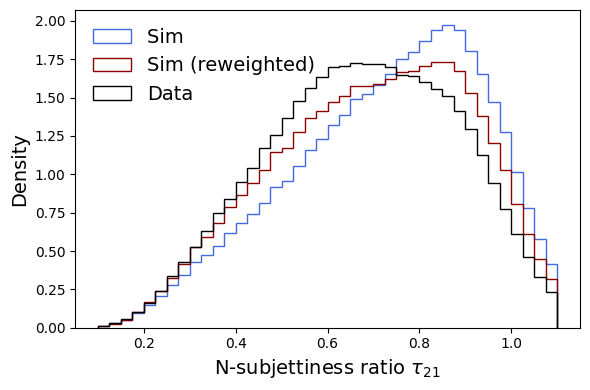

Plotting reweighted reco-level distribtuion


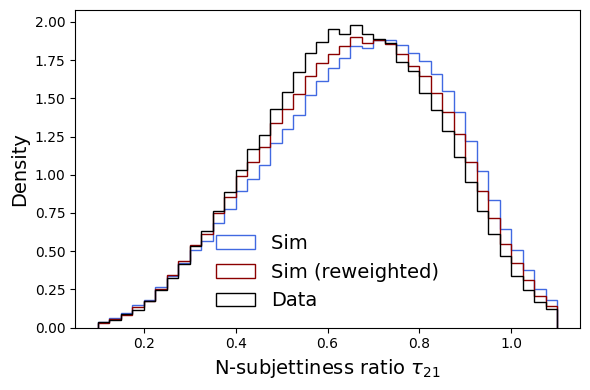

Starting with iteration 1
Building reco-level classifier
Training reco-level classifier
Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3842, Time = 14.2s
    Epoch 6: Avg loss = 1.3835, Time = 101.5s
    Epoch 12: Avg loss = 1.3833, Time = 189.7s
    Epoch 18: Avg loss = 1.3831, Time = 275.8s
    Epoch 24: Avg loss = 1.3829, Time = 361.9s
Training finished in 434.0 seconds.
Evaluating reco-level classifier
Plotting reweighted reco-level distribtuion


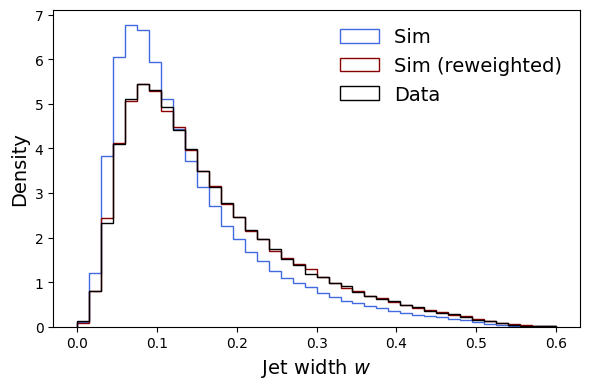

Plotting reweighted particle-level distribtuion


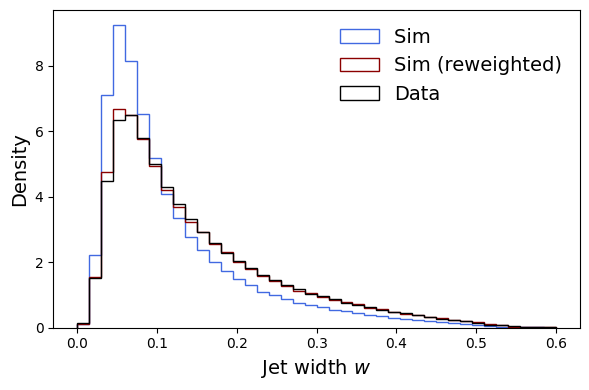

Plotting reweighted reco-level distribtuion


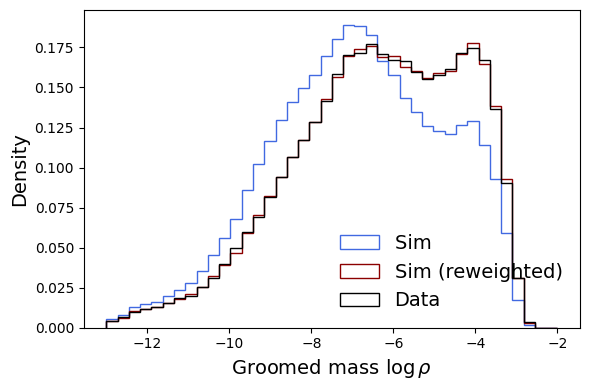

Plotting reweighted particle-level distribtuion


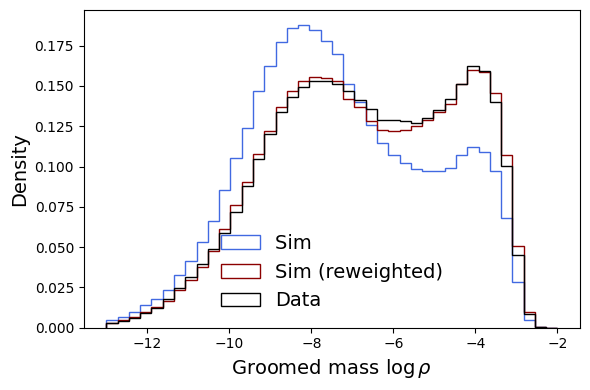

Plotting reweighted reco-level distribtuion


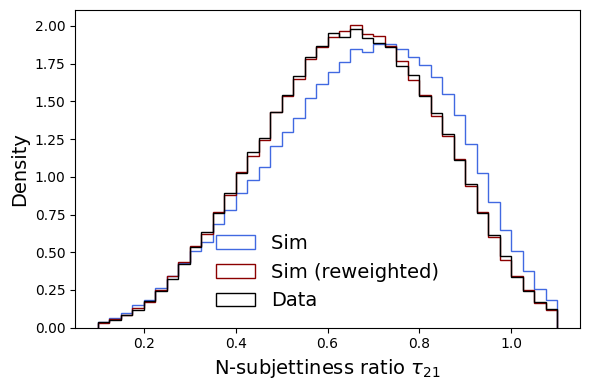

Plotting reweighted particle-level distribtuion


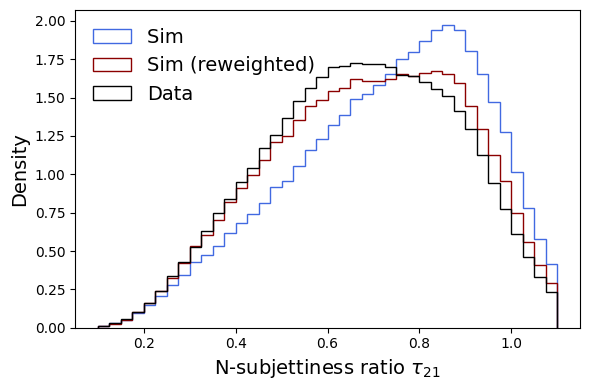

Building part-level classifier
Training part-level classifier
Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3663, Time = 14.6s
    Epoch 6: Avg loss = 1.3630, Time = 101.4s
    Epoch 12: Avg loss = 1.3629, Time = 188.0s
    Epoch 18: Avg loss = 1.3629, Time = 273.2s
    Epoch 24: Avg loss = 1.3629, Time = 359.4s
Training finished in 431.3 seconds.
Evaluating part-level classifier
Plotting reweighted reco-level and particle-level observables.
Plotting reweighted particle-level distribtuion


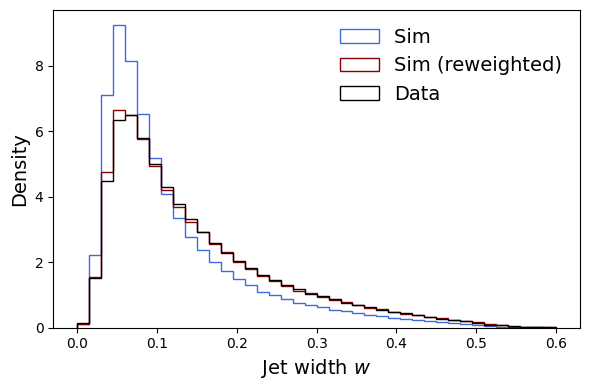

Plotting reweighted reco-level distribtuion


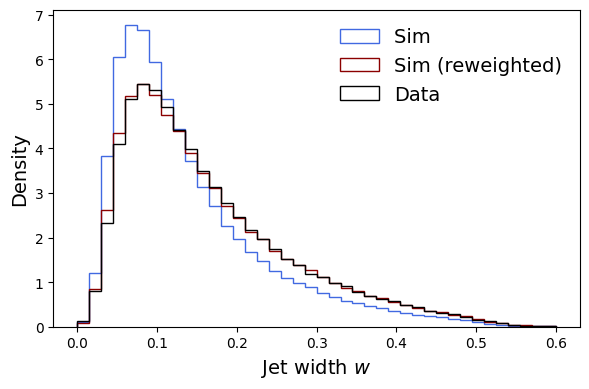

Plotting reweighted particle-level distribtuion


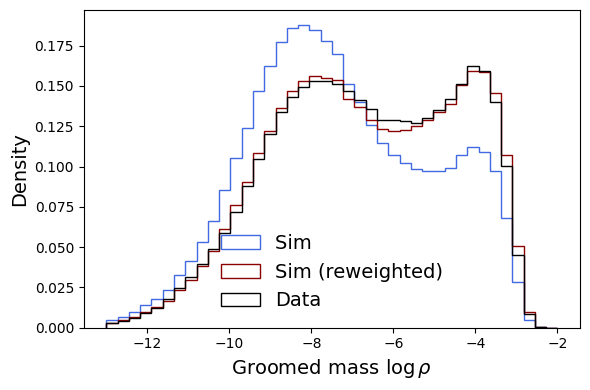

Plotting reweighted reco-level distribtuion


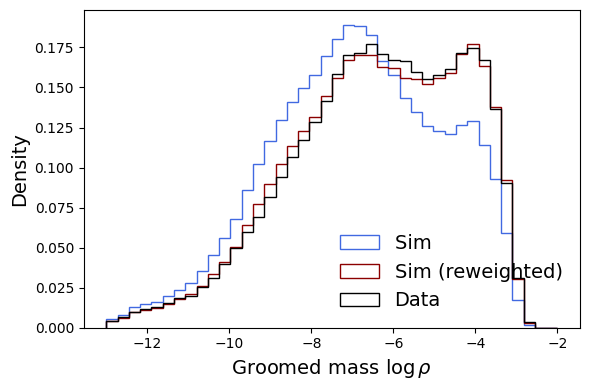

Plotting reweighted particle-level distribtuion


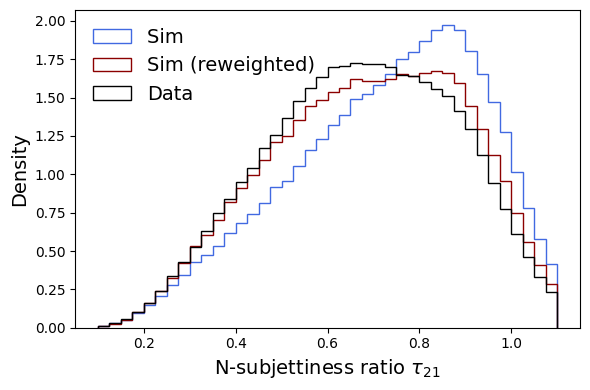

Plotting reweighted reco-level distribtuion


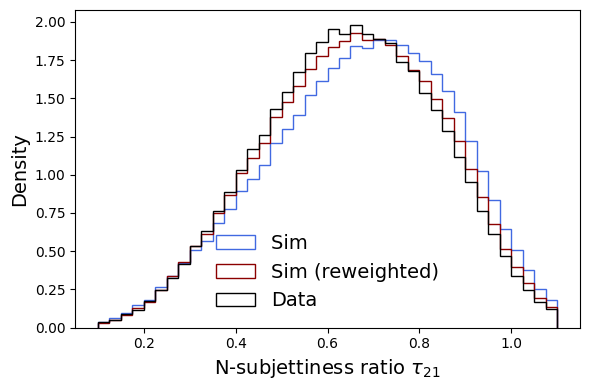

Starting with iteration 2
Building reco-level classifier
Training reco-level classifier
Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3852, Time = 14.2s
    Epoch 6: Avg loss = 1.3849, Time = 100.3s
    Epoch 12: Avg loss = 1.3848, Time = 186.6s
    Epoch 18: Avg loss = 1.3847, Time = 272.2s
    Epoch 24: Avg loss = 1.3846, Time = 358.0s
Training finished in 429.0 seconds.
Evaluating reco-level classifier
Plotting reweighted reco-level distribtuion


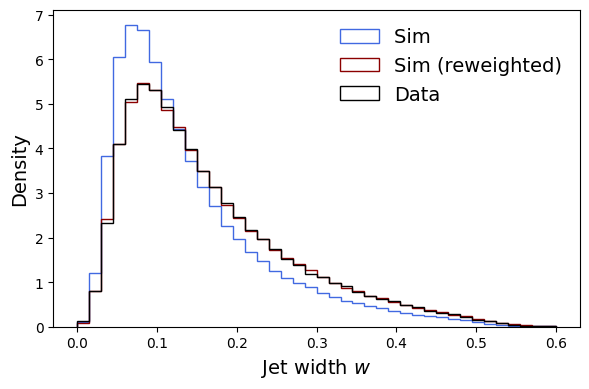

Plotting reweighted particle-level distribtuion


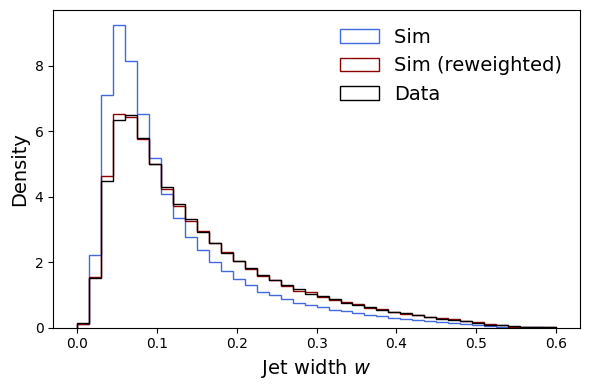

Plotting reweighted reco-level distribtuion


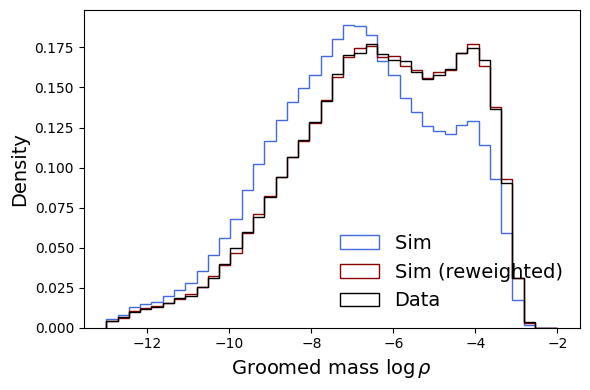

Plotting reweighted particle-level distribtuion


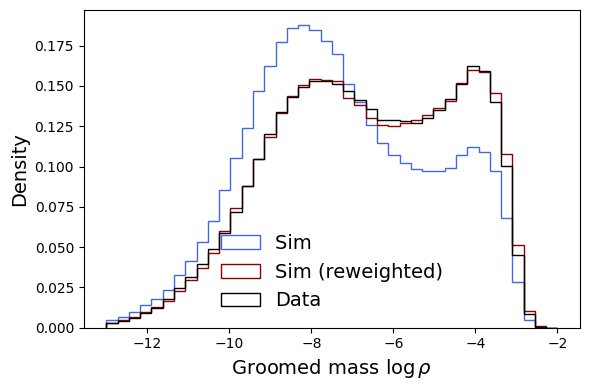

Plotting reweighted reco-level distribtuion


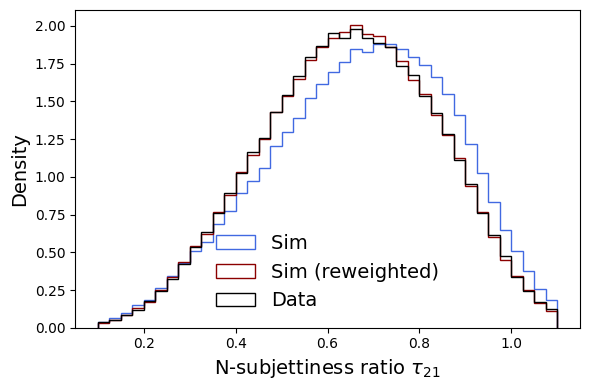

Plotting reweighted particle-level distribtuion


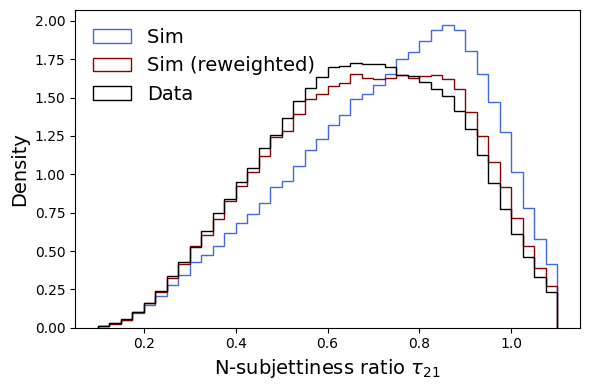

Building part-level classifier
Training part-level classifier
Training classifier for 30 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3630, Time = 14.0s
    Epoch 6: Avg loss = 1.3600, Time = 99.2s
    Epoch 12: Avg loss = 1.3600, Time = 183.7s
    Epoch 18: Avg loss = 1.3600, Time = 269.4s
    Epoch 24: Avg loss = 1.3600, Time = 354.0s
Training finished in 424.4 seconds.
Evaluating part-level classifier
Plotting reweighted reco-level and particle-level observables.
Plotting reweighted particle-level distribtuion


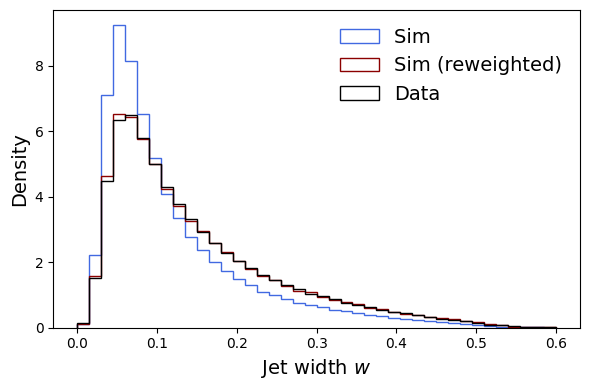

Plotting reweighted reco-level distribtuion


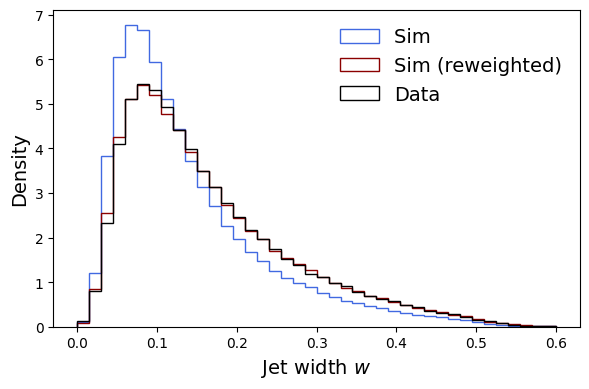

Plotting reweighted particle-level distribtuion


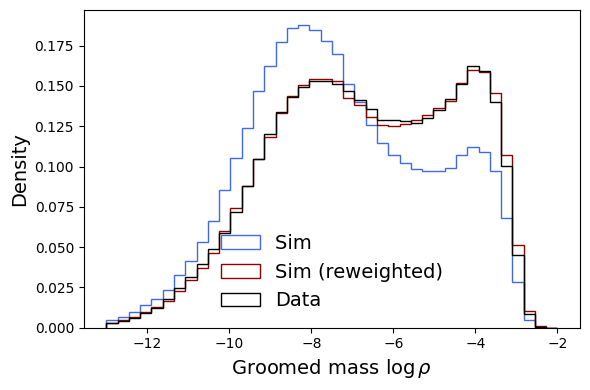

Plotting reweighted reco-level distribtuion


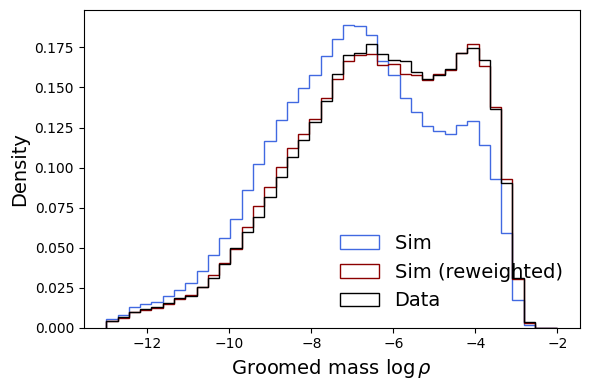

Plotting reweighted particle-level distribtuion


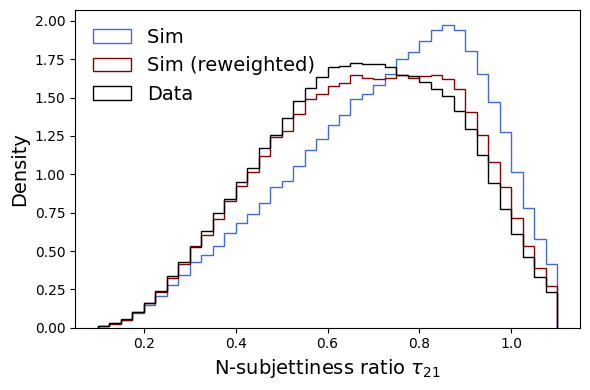

Plotting reweighted reco-level distribtuion


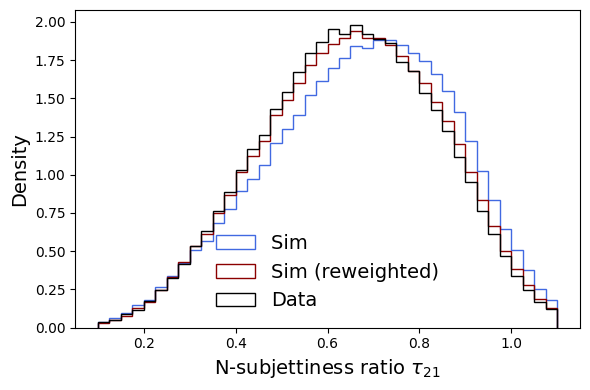

In [ ]:
iterations = 3

nu_part_train = torch.ones((reco_data_train.size(0)), dtype=torch.float, device=device )
nu_part_test = torch.ones((reco_data_test.size(0)), dtype=torch.float, device=device )
for i in range(iterations):
    print(f"Starting with iteration {i}")
    print("Building reco-level classifier")
    # Build the classifier
    reco_classifier = Classifier(dims_in=3, params=classifier_params)

    print("Training reco-level classifier")
    # Train the classifier using reoc-level data (true) and reco-level simulation (fake) data
    reco_classifier.train_classifier(
        data_true=reco_data_proc_train,
        data_fake=reco_sim_proc_train,
        weights_fake=nu_part_train
    )

    print("Evaluating reco-level classifier")
    w_reco_train = reco_classifier.evaluate(
    data=reco_sim_proc_train,
    )
    w_reco_train *= nu_part_train
    w_reco_test = reco_classifier.evaluate(
    data=reco_sim_proc_test,
    )
    w_reco_test *= nu_part_test

    for i in range(n_features):
      print("Plotting reweighted reco-level distribtuion")
      plot_reweighted_distribution(
          true=reco_data_test[:, i],
          fake=reco_sim_test[:, i],
          weights=w_reco_test.cpu(),
          bins= binning[i].cpu(),
          name = names[i]
      )
      print("Plotting reweighted particle-level distribtuion")
      plot_reweighted_distribution(
          true=part_data[:, i],
          fake=part_sim_test[:, i],
          weights=w_reco_test.cpu(),
          bins= binning[i].cpu(),
          name = names[i]
      )

    print("Building part-level classifier")
    # Build the classifier
    part_classifier = Classifier(dims_in=3, params=classifier_params)

    print("Training part-level classifier")
    # Train the classifier using reoc-level data (true) and reco-level simulation (fake) data
    part_classifier.train_classifier(
        data_true=part_sim_proc_train,
        data_fake=part_sim_proc_train,
        weights_true= w_reco_train
    )
    print("Evaluating part-level classifier")
    nu_part_train = part_classifier.evaluate(
        data=part_sim_proc_train,
    )
    nu_part_test = part_classifier.evaluate(
        data=part_sim_proc_test,
    )

    print("Plotting reweighted reco-level and particle-level observables.")
    for i in range(n_features):
      print("Plotting reweighted particle-level distribtuion")
      plot_reweighted_distribution(
          true=part_data[:, i],
          fake=part_sim_test[:, i],
          weights=nu_part_test.cpu(),
          bins= binning[i].cpu(),
          name = names[i]
      )
      print("Plotting reweighted reco-level distribtuion")
      plot_reweighted_distribution(
          true=reco_data_test[:, i],
          fake=reco_sim_test[:, i],
          weights=nu_part_test.cpu(),
          bins= binning[i].cpu(),
          name = names[i]
      )